# 3. Regression
In this notebook we will finally run our regression models. For that purpose, we are importing the necessary libraries and functions from our ```modules``` folder. We are also importing our extracted dataframe.

In this notebook we are applying bootstrapping to the randomized grid search and the ML predictions

In [71]:
# Warnings
import warnings
warnings.filterwarnings("ignore")

# Basic Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import seaborn as sns
from scipy import stats
from scipy.stats import randint
from functools import reduce

# Statsmodels
import statsmodels.api as sm
import pmdarima as pmd
from pmdarima.arima import auto_arima
from statsmodels.tsa.api import VAR
from statsmodels.tsa.vector_ar.var_model import VARResults
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

# Machine Learning models
import sklearn.model_selection as skm
import sklearn.linear_model as skl
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit, RandomizedSearchCV
from sklearn.linear_model import Ridge, Lasso, ElasticNet, ElasticNetCV, LinearRegression, LassoLars, Lars
from sklearn.linear_model import LinearRegression
import joblib

from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error,
    median_absolute_error,
    r2_score,
    precision_score

)
from sklearn.utils import resample
from xgboost import XGBRegressor
from sklearn.svm import SVR
# Bayesian Optimizer
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical



In [2]:
# We import our own functions
import sys
sys.path.append('../../..')  # Move two levels up to the project root
from modules.functions import *

In [3]:
df = pd.read_csv('../../../input/df_raw.csv', parse_dates=['Fecha'], index_col='Fecha')
df.tail()

,CPI,Core CPI - Services - Dining Out,Terms of Trade - Exports,Terms of Trade - Imports,Chicken Placements (thousands),Private Credit - ME - Consumption (mill US$),Private Credit - MN - Consumption (mill S/),Private Credit - MN - Mortgage (mill S/),Capacity Utilization - Food & Beverages,Electricity Production - Lima (GWh),...,"Dependent Worker (3-month MA, thousands)","Unpaid Worker (3-month MA, thousands)","Firms 1-10 Workers (3-month MA, thousands)","Firms 11-50 Workers (3-month MA, thousands)","Firms 51+ Workers (3-month MA, thousands)","Adequately Employed (3-month MA, thousands)","Underemployed (3-month MA, thousands)",Employment Ratio (3-month MA),Monthly Income (3-month MA),"Unemployment Rate (3-month MA, %)"
Fecha,,,,,,,,,,,,,,,,,,,,,
2023-08-01,0.182324,0.493711,1.222114,0.637752,0.019147,0.003929,0.008218,0.005268,0.073791,0.053100,...,0.003075,-0.009630,0.003672,0.025094,-0.016357,0.010773,-0.014092,-0.002963,0.007206,0.059598
2023-09-01,0.133933,0.466855,2.545351,0.498539,-0.032237,0.006853,0.002300,0.009073,0.093072,0.000330,...,-0.012249,-0.236708,0.000451,-0.022502,-0.003658,-0.002652,-0.004252,-0.006672,-0.003658,0.014112
2023-10-01,0.085365,0.439759,-1.221888,0.418250,0.016049,0.016984,0.003725,0.006669,-0.043358,-0.031960,...,-0.004473,-0.023207,0.014899,-0.061290,0.005309,0.009151,-0.004133,0.000334,0.005766,-0.026198
2023-11-01,0.036736,0.412382,0.766457,-0.877823,0.008049,0.005182,0.000605,0.006279,0.015830,-0.102170,...,0.004042,-0.036390,0.024137,-0.017521,-0.003176,-0.012732,0.048607,0.008813,-0.019686,0.001051
2023-12-01,-0.011845,0.384683,1.103257,-2.321367,-0.027293,-0.025853,-0.002890,0.003147,-0.080944,-0.195104,...,0.002075,0.255287,0.005681,0.010032,0.002840,0.014463,-0.007180,0.002026,0.006210,-0.027032


In [4]:
df_lags = pd.read_csv('../../../input/df_lags.csv', parse_dates=['Fecha'], index_col='Fecha')
df_lags.tail()

,CPI,Core CPI - Services - Dining Out_lag_1,Core CPI - Services - Dining Out_lag_2,Core CPI - Services - Dining Out_lag_3,Terms of Trade - Exports_lag_1,Terms of Trade - Exports_lag_2,Terms of Trade - Exports_lag_3,Terms of Trade - Imports_lag_1,Terms of Trade - Imports_lag_2,Terms of Trade - Imports_lag_3,...,"Underemployed (3-month MA, thousands)_lag_3",Employment Ratio (3-month MA)_lag_1,Employment Ratio (3-month MA)_lag_2,Employment Ratio (3-month MA)_lag_3,Monthly Income (3-month MA)_lag_1,Monthly Income (3-month MA)_lag_2,Monthly Income (3-month MA)_lag_3,"Unemployment Rate (3-month MA, %)_lag_1","Unemployment Rate (3-month MA, %)_lag_2","Unemployment Rate (3-month MA, %)_lag_3"
Fecha,,,,,,,,,,,,,,,,,,,,,
2023-08-01,0.182324,0.520360,0.546821,0.573096,0.108717,1.411009,-3.488401,0.205259,-0.477097,-1.960619,...,0.007109,-0.001862,0.006970,-0.008402,0.006234,0.010346,0.017119,-0.043834,-0.033525,-0.041515
2023-09-01,0.133933,0.493711,0.520360,0.546821,1.222114,0.108717,1.411009,0.637752,0.205259,-0.477097,...,-0.000207,-0.002963,-0.001862,0.006970,0.007206,0.006234,0.010346,0.059598,-0.043834,-0.033525
2023-10-01,0.085365,0.466855,0.493711,0.520360,2.545351,1.222114,0.108717,0.498539,0.637752,0.205259,...,-0.018183,-0.006672,-0.002963,-0.001862,-0.003658,0.007206,0.006234,0.014112,0.059598,-0.043834
2023-11-01,0.036736,0.439759,0.466855,0.493711,-1.221888,2.545351,1.222114,0.418250,0.498539,0.637752,...,-0.014092,0.000334,-0.006672,-0.002963,0.005766,-0.003658,0.007206,-0.026198,0.014112,0.059598
2023-12-01,-0.011845,0.412382,0.439759,0.466855,0.766457,-1.221888,2.545351,-0.877823,0.418250,0.498539,...,-0.004252,0.008813,0.000334,-0.006672,-0.019686,0.005766,-0.003658,0.001051,-0.026198,0.014112


In [5]:
df = df[:'2019-12-01']
df_lags = df_lags[:'2019-12-01'] 

## 3.1 Benchmark models

In the first section, we first run our benchmark econometric models: ```Random Walk (RW)```,  ```Autoregressive Integrated Moving Average (ARIMA)``` and ```Vector Autoregression (VAR)``` processes

### 3.1.1 Random Walk (RW)

In [7]:
forecast_horizons = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

# We define our target variable
target = 'CPI'

# We only use CPI as Random Walk is an univariate process
df_CPI = pd.DataFrame(df_lags.CPI)

# We create our train and test set
train_set = df_CPI[df_CPI.index < '2019-01-01']
test_set  = df_CPI[df_CPI.index >= '2019-01-01']

predictions = {}

for h in forecast_horizons:
    # We get the values h horizons before
    predicted_value = train_set.iloc[-1, 0] 

    # We save it for horizon h
    predictions[h] = predicted_value

predicted = pd.DataFrame([predictions]).transpose().reset_index()

predicted.columns = ['Horizon', 'Prediction']

predicted = predicted.set_index(test_set.index)

predicted

,Horizon,Prediction
Fecha,,
2019-01-01,1,0.19049
2019-02-01,2,0.19049
2019-03-01,3,0.19049
2019-04-01,4,0.19049
2019-05-01,5,0.19049
2019-06-01,6,0.19049
2019-07-01,7,0.19049
2019-08-01,8,0.19049
2019-09-01,9,0.19049


In [8]:
# We create our results dataframe, concatenating the predicted and the actual values
results_rw = pd.concat([predicted, test_set[target]], axis=1)
results_rw.rename(columns={'Horizon': 'Horizon', 'Prediction': 'Predicted', 'CPI': 'Actual'}, inplace=True)
results_rw

,Horizon,Predicted,Actual
Fecha,,,
2019-01-01,1,0.19049,0.183963
2019-02-01,2,0.19049,0.175141
2019-03-01,3,0.19049,0.166761
2019-04-01,4,0.19049,0.160654
2019-05-01,5,0.19049,0.157488
2019-06-01,6,0.19049,0.156027
2019-07-01,7,0.19049,0.155721
2019-08-01,8,0.19049,0.156584
2019-09-01,9,0.19049,0.156844


In [9]:
# We get our metrics using our function
RMSE_rw, MAPE_rw = get_metrics(results_rw, 'RW')
metrics_rw = pd.concat([RMSE_rw, MAPE_rw], axis = 1)
metrics_rw

,RMSE_RW,MAPE_RW
1,0.006527,0.035478
2,0.011793,0.061556
3,0.016746,0.088469
4,0.020805,0.112780
5,0.023751,0.132134
6,0.025846,0.146924
7,0.027300,0.157831
8,0.028210,0.165169
9,0.028865,0.170652
10,0.029558,0.176242


### 3.1.2 Autoregressive Integrated Moving Average (ARIMA)

In [10]:
# We only use CPI as Random Walk is an univariate process
df_CPI = pd.DataFrame(df_lags.CPI)

# We create our train and test set
train_set = df_CPI[df_CPI.index < '2019-01-01']
test_set  = df_CPI[df_CPI.index >= '2019-01-01']

In [12]:
# We find the best SARIMA model
autoarima = pmd.auto_arima(
        y = train_set,
        start_p=1,
        start_q=0,
        seasonal=True,
        max_p=12,
        max_d=1,
        max_q=6,
        max_P=12,
        max_D=1,
        max_Q=6,
        m=4,
        n_jobs=-1,
        suppress_warnings=True,
        )

# We indicate the seasonal order for monthly data
seasonal_order = (1, 1, 1, 12)

# We create our ARIMA model
model = SARIMAX(train_set,
                order=autoarima.order,
                seasonal_order=autoarima.seasonal_order,
                enforce_stationarity = False,
                enforce_invertibility = False)
        
# We fit the model
model_fit = model.fit()

# We forecast for the next 12 horizons
forecast_values = model_fit.get_forecast(steps=12)
predicted = pd.DataFrame(forecast_values.predicted_mean, index = test_set.index)

# We create our results dataframe, concatenating the predicted and the actual values
results = pd.concat([predicted, test_set[target]], axis=1)
results.rename(columns={'predicted_mean': 'Predicted', 'CPI': 'Actual'}, inplace=True)
results

,Predicted,Actual
Fecha,,
2019-01-01,0.183810,0.183963
2019-02-01,0.174572,0.175141
2019-03-01,0.163781,0.166761
2019-04-01,0.152346,0.160654
2019-05-01,0.141179,0.157488
2019-06-01,0.131144,0.156027
2019-07-01,0.122793,0.155721
2019-08-01,0.116382,0.156584
2019-09-01,0.111980,0.156844


In [13]:
# We get our metrics using our function
RMSE_arima, MAPE_arima = get_metrics(results, 'ARIMA')
metrics_arima= pd.concat([RMSE_arima, MAPE_arima], axis = 1)
metrics_arima

,RMSE_ARIMA,MAPE_ARIMA
1,0.000153,0.000833
2,0.000417,0.002043
3,0.001754,0.007318
4,0.004423,0.018416
5,0.008297,0.035445
6,0.012672,0.056118
7,0.017103,0.078309
8,0.021401,0.100613
9,0.025115,0.121217
10,0.027880,0.138575


<Axes: >

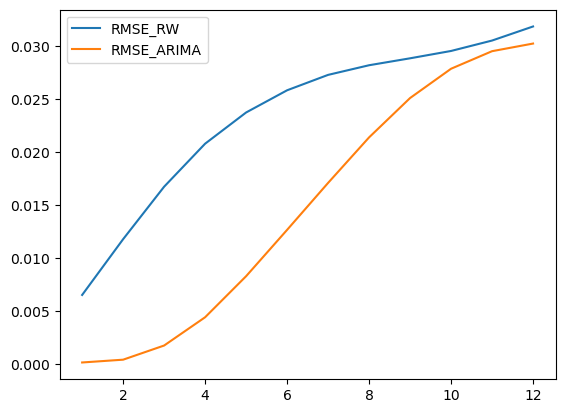

In [14]:
rmse_econometrics = pd.concat([RMSE_rw, RMSE_arima], axis=1)

rmse_econometrics.plot()

### 3.1.3 Vector autoregression (VAR)

In [15]:
# We define our target variable, as well as our train and test set
target = 'CPI'
train_set = df[df.index < '2019-01-01']
test_set  = df[df.index >= '2019-01-01']

In [16]:
# We model our VAR including up to two lags
model_var = VAR(df)
model_fit = model_var.fit(3)

In [17]:
# Summary of the model
# model_fit.summary()

In [18]:
# We forecast for the next 12 months
preds = model_fit.forecast(df.values[-3:], 12)
preds = pd.DataFrame(preds, index = test_set[target].index)[0]

# We create our results dataframe, concatenating the predicted and the actual values
results_var = pd.concat([preds, test_set[target]],axis=1)
results_var.rename(columns={'CPI': 'Actual', 0: 'Predicted'}, inplace=True)
results_var

,Predicted,Actual
Fecha,,
2019-01-01,0.128511,0.183963
2019-02-01,0.114930,0.175141
2019-03-01,0.124422,0.166761
2019-04-01,0.121974,0.160654
2019-05-01,0.122877,0.157488
2019-06-01,0.137699,0.156027
2019-07-01,0.147662,0.155721
2019-08-01,0.159871,0.156584
2019-09-01,0.176011,0.156844


In [19]:
# We get our metrics using our function
RMSE_var, MAPE_var = get_metrics(results_var, 'VAR')
metrics_var= pd.concat([RMSE_var, MAPE_var], axis = 1)
metrics_var

,RMSE_VAR,MAPE_VAR
1,0.055452,0.301432
2,0.057881,0.322609
3,0.053207,0.299703
4,0.049973,0.284968
5,0.047301,0.271929
6,0.043823,0.246185
7,0.040687,0.218409
8,0.038077,0.193732
9,0.036463,0.185785
10,0.036081,0.188097


<Axes: >

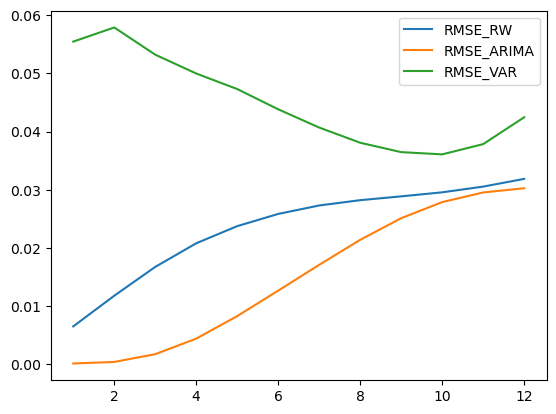

In [20]:
rmse_econometrics = pd.concat([RMSE_rw, RMSE_arima, RMSE_var], axis=1)

rmse_econometrics.plot()

## 3.2 Machine learning models

In the second section, we run our machine learning models: ```Ridge Regression (Ridge)```,  ```Least Absolute Shrinkage and Selection Operator (LASSO)``` and ```Random Forest (RF)``` models

### 3.2.1 Ridge Regression (Ridge)

In [21]:
target = "CPI"
Y = pd.DataFrame(df_lags[target])
X = df_lags.drop(columns=[target])

train_set = df_lags[df_lags.index <= '2019-01-01']
test_set  = df_lags[df_lags.index >= '2019-01-01']

y_train = train_set[target]
y_test  = test_set[target]
X_train = train_set.loc[:, train_set.columns != target]
X_test  = test_set.loc[:, test_set.columns != target]

# We define the model
tscv = TimeSeriesSplit(n_splits=5, test_size= 12)
scaler = StandardScaler()

# Define model
model = Pipeline([
    ('scaler', scaler),
    ('regressor', ElasticNet(l1_ratio=0, random_state=2024))  
])

# Define grid search
grid_params_ridge = {
    'regressor__alpha': np.linspace(0.01, 10, 1000) 
}


# We implement the gridsearch
grid_search = RandomizedSearchCV( model, grid_params_ridge, cv = tscv, scoring = 'neg_mean_squared_error', n_iter=500, random_state=2024)
grid_search.fit( X_train, y_train )
grid_search_ridge = pd.DataFrame( grid_search.cv_results_ )

ridge_model  = grid_search.best_estimator_
ridge_params = grid_search.best_params_

#### Bootstrapping

In [24]:
np.random.seed(2024)
n_bootstraps = 1000
bootstrap_predictions_ridge = np.zeros((n_bootstraps, len(y_test)))
boostrap_params_ridge = np.zeros((n_bootstraps, 1))

for i in range(n_bootstraps):
    n_iter = np.random.randint(25, 150)
    print(f'Number of iterations: {n_iter}')
    grid_search = RandomizedSearchCV( model, grid_params_ridge, cv = tscv, scoring = 'neg_mean_squared_error', n_iter=n_iter, random_state=i)
    grid_search.fit( X_train, y_train )

    ridge_model  = grid_search.best_estimator_
    ridge_params = grid_search.best_params_

    # Make predictions
    y_pred_bootstrap = ridge_model.predict(X_test)
    
    # Save predictions
    bootstrap_predictions_ridge[i] = y_pred_bootstrap
    boostrap_params_ridge[i] = ridge_params['regressor__alpha']
    print(f'Bootstrap {i+1} of {n_bootstraps} completed')

# We get the mean and median of the alphas
alpha_ridge_mean = np.mean(boostrap_params_ridge)
alpha_ridge_median = np.median(boostrap_params_ridge)

# Point forecast
y_pred_mean = np.mean(bootstrap_predictions_ridge, axis=0)

# Confidence Intervals
ci_lower = np.percentile(bootstrap_predictions_ridge, 2.5, axis=0)
ci_upper = np.percentile(bootstrap_predictions_ridge, 97.5, axis=0)

# Dataframe with results
results_ridge = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred_mean,
    'CI Lower': ci_lower,
    'CI Upper': ci_upper
})

Bootstrap 1 of 1000 completed
Bootstrap 2 of 1000 completed
Bootstrap 3 of 1000 completed
Bootstrap 4 of 1000 completed
Bootstrap 5 of 1000 completed
Bootstrap 6 of 1000 completed
Bootstrap 7 of 1000 completed
Bootstrap 8 of 1000 completed
Bootstrap 9 of 1000 completed
Bootstrap 10 of 1000 completed
Bootstrap 11 of 1000 completed
Bootstrap 12 of 1000 completed
Bootstrap 13 of 1000 completed
Bootstrap 14 of 1000 completed
Bootstrap 15 of 1000 completed
Bootstrap 16 of 1000 completed
Bootstrap 17 of 1000 completed
Bootstrap 18 of 1000 completed
Bootstrap 19 of 1000 completed
Bootstrap 20 of 1000 completed
Bootstrap 21 of 1000 completed
Bootstrap 22 of 1000 completed
Bootstrap 23 of 1000 completed
Bootstrap 24 of 1000 completed
Bootstrap 25 of 1000 completed
Bootstrap 26 of 1000 completed
Bootstrap 27 of 1000 completed
Bootstrap 28 of 1000 completed
Bootstrap 29 of 1000 completed
Bootstrap 30 of 1000 completed
Bootstrap 31 of 1000 completed
Bootstrap 32 of 1000 completed
Bootstrap 33 of 1

#### Parameters

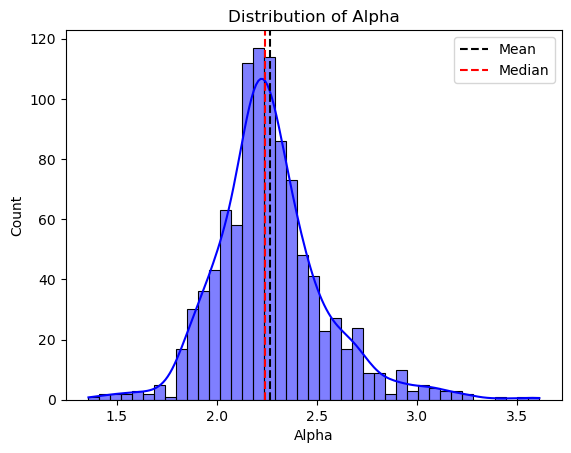

In [39]:
bootstrap_params_df = pd.DataFrame(boostrap_params_ridge, columns=['Alpha'])

sns.histplot(bootstrap_params_df.Alpha, color='blue', kde=True)
plt.axvline(x=alpha_ridge_mean, color='black', linestyle='--', label='Mean')
plt.axvline(x=alpha_ridge_median, color='red', linestyle='--', label='Median')
plt.legend()
plt.title('Distribution of Alpha')
plt.savefig('../../../output/3_Regression/analysis_16/h19/ridge_bootstrap.png')
plt.show()

#### Plot

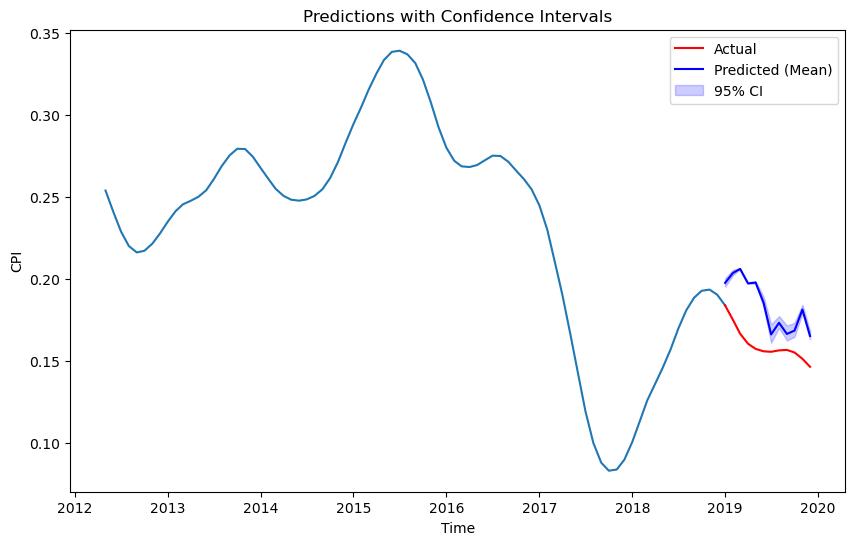

In [50]:
plt.figure(figsize=(10, 6))
plt.plot(df_lags[df_lags.index <= '2019-01-01']["CPI"], label=None)
plt.plot(results_ridge.index, results_ridge['Actual'], label='Actual', color='red')
plt.plot(results_ridge.index, results_ridge['Predicted'], label='Predicted (Mean)', color='blue')
plt.fill_between(results_ridge.index, results_ridge['CI Lower'], results_ridge['CI Upper'], color='blue', alpha=0.2, label='95% CI')
plt.xlabel('Time')
plt.ylabel('CPI')
plt.title('Predictions with Confidence Intervals')
plt.legend()
plt.savefig('../../../output/3_Regression/analysis_16/h19/ridge_predictions.png')
plt.show()


#### Predictors

In [78]:
pred_vars = X_train.columns.to_list()
coefficients = ridge_model.named_steps['regressor'].coef_
vars_df_ridge      = pd.DataFrame( {'Var': X_train.columns, 'Coefficient': coefficients } )
vars_df_ridge      = vars_df_ridge.reindex( vars_df_ridge[ 'Coefficient' ].abs().sort_values( ascending = False ).index )
vars_df_ridge.to_excel( f'../../../output/3_Regression/analysis_16/h19/coef_ridge_h19.xlsx' )


#### Metrics

<Axes: >

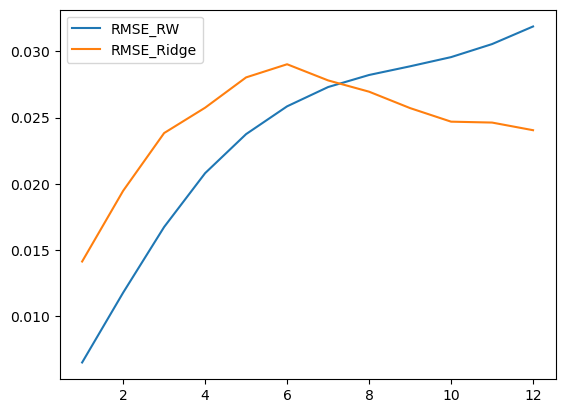

In [ ]:
RMSE_ridge, MAPE_ridge = get_metrics(results_ridge, 'Ridge')

pd.concat([RMSE_rw, RMSE_ridge], axis=1).plot()

### 3.2.2 Lasso Regression (Lasso)

In [ ]:
target = "CPI"
Y = pd.DataFrame(df_lags[target])
X = df_lags.drop(columns=[target])

train_set = df_lags[df_lags.index < '2019-01-01']
test_set  = df_lags[df_lags.index >= '2019-01-01']

y_train = train_set[target]
y_test  = test_set[target]
X_train = train_set.loc[:, train_set.columns != target]
X_test  = test_set.loc[:, test_set.columns != target]

# We define the model
scaler = StandardScaler()

# Define model
model = Pipeline([
    ('scaler', scaler),
    ('regressor', ElasticNet(l1_ratio=1, random_state=2024))  
])

# Define grid search
grid_params_lasso = {
    'regressor__alpha': np.linspace(0.01, 10, 1000) 
}


#### Bootstrapping

In [ ]:
np.random.seed(2024)
n_bootstraps = 1000
bootstrap_predictions_lasso = np.zeros((n_bootstraps, len(y_test)))
boostrap_params_lasso = np.zeros((n_bootstraps, 1))

for i in range(n_bootstraps):
    n_iter = np.random.randint(25, 150)
    print(f'Number of iterations: {n_iter}')
    grid_search = RandomizedSearchCV( model, grid_params_lasso, cv = tscv, scoring = 'neg_mean_squared_error', n_iter=n_iter, random_state=i)
    grid_search.fit( X_train, y_train )

    lasso_model  = grid_search.best_estimator_
    lasso_params = grid_search.best_params_

    # Make predictions
    y_pred_bootstrap = lasso_model.predict(X_test)
    
    # Save predictions
    bootstrap_predictions_lasso[i] = y_pred_bootstrap
    boostrap_params_lasso[i] = lasso_params['regressor__alpha']
    print(f'Bootstrap {i+1} of {n_bootstraps} completed')

# We get the mean and median of the alphas
alpha_lasso_mean = np.mean(boostrap_params_lasso)
alpha_lasso_median = np.median(boostrap_params_lasso)

# Point forecast
y_pred_mean = np.mean(bootstrap_predictions_lasso, axis=0)

# Confidence Intervals
ci_lower = np.percentile(bootstrap_predictions_lasso, 2.5, axis=0)
ci_upper = np.percentile(bootstrap_predictions_lasso, 97.5, axis=0)

# Dataframe with results
results_lasso = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred_mean,
    'CI Lower': ci_lower,
    'CI Upper': ci_upper
})

#### Parameters

In [ ]:
bootstrap_params_df = pd.DataFrame(boostrap_params_lasso, columns=['Alpha'])

sns.histplot(bootstrap_params_df.Alpha, color='blue', kde=True)
plt.axvline(x=alpha_lasso_mean, color='black', linestyle='--', label='Mean')
plt.axvline(x=alpha_lasso_median, color='red', linestyle='--', label='Median')
plt.legend()
plt.title('Distribution of Alpha')
plt.savefig('../../../output/3_Regression/analysis_16/h19/lasso_bootstrap.png')
plt.show()

#### Plot

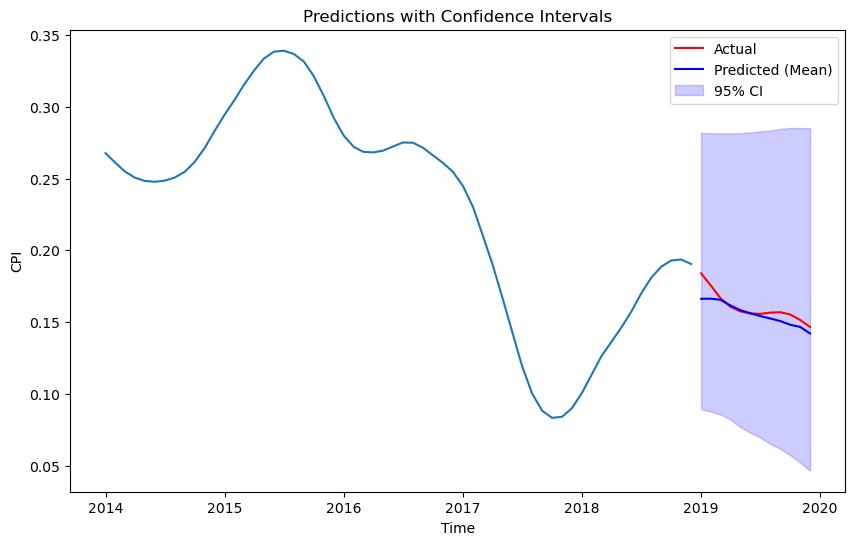

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(y_train['2014':], label=None)
plt.plot(results_lasso.index, results_lasso['Actual'], label='Actual', color='red')
plt.plot(results_lasso.index, results_lasso['Predicted'], label='Predicted (Mean)', color='blue')
plt.fill_between(results_lasso.index, results_lasso['CI Lower'], results_lasso['CI Upper'], color='blue', alpha=0.2, label='95% CI')
plt.xlabel('Time')
plt.ylabel('CPI')
plt.title('Predictions with Confidence Intervals')
plt.legend()
plt.savefig('../../../output/3_Regression/analysis_16/h19/lasso_predictions.png')
plt.show()

#### Predictors

In [ ]:
pred_vars = X_train.columns.to_list()
coefficients = lasso_model.named_steps['regressor'].coef_
vars_df_lasso      = pd.DataFrame( {'Var': X_train.columns, 'Coefficient': coefficients } )
vars_df_lasso      = vars_df_lasso.reindex( vars_df_lasso[ 'Coefficient' ].abs().sort_values( ascending = False ).index )
vars_df_lasso.to_excel( f'../../../output/3_Regression/analysis_16/h19/coef_lasso_h19.xlsx' )

#### Metrics

<Axes: >

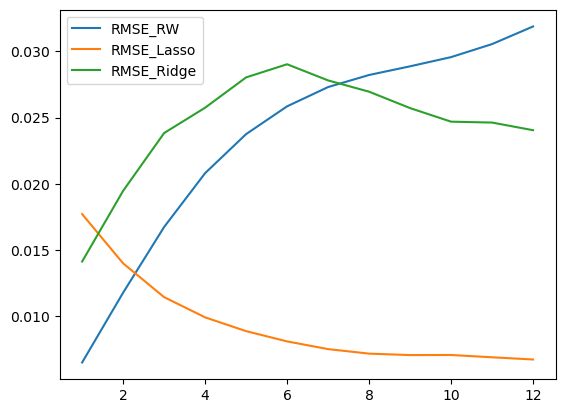

In [ ]:
RMSE_lasso, MAPE_lasso = get_metrics(results_lasso, 'Lasso')
pd.concat([RMSE_rw, RMSE_lasso, RMSE_ridge], axis=1).plot()

### 3.2.3 Elastic Net (EN)

In [ ]:
target = "CPI"
Y = pd.DataFrame(df_lags[target])
X = df_lags.drop(columns=[target])

train_set = df_lags[df_lags.index < '2019-01-01']
test_set  = df_lags[df_lags.index >= '2019-01-01']

y_train = train_set[target]
y_test  = test_set[target]
X_train = train_set.loc[:, train_set.columns != target]
X_test  = test_set.loc[:, test_set.columns != target]

# We define the model
scaler = StandardScaler()

# Define model
model = Pipeline([
    ('scaler', scaler),
    ('regressor', ElasticNet(l1_ratio=0.5, random_state=2024))  
])

# Define grid search
grid_params_en = {
    'regressor__alpha': np.linspace(0.01, 10, 1000),
}



#### Bootstrapping

In [ ]:
np.random.seed(2024)
n_bootstraps = 1000
bootstrap_predictions_en = np.zeros((n_bootstraps, len(y_test)))
boostrap_params_en = np.zeros((n_bootstraps, 1))

for i in range(n_bootstraps):
    n_iter = np.random.randint(25, 150)
    print(f'Number of iterations: {n_iter}')
    grid_search = RandomizedSearchCV( model, grid_params_en, cv = tscv, scoring = 'neg_mean_squared_error', n_iter=n_iter, random_state=i)
    grid_search.fit( X_train, y_train )

    en_model  = grid_search.best_estimator_
    en_params = grid_search.best_params_

    # Make predictions
    y_pred_bootstrap = en_model.predict(X_test)
    
    # Save predictions
    bootstrap_predictions_en[i] = y_pred_bootstrap
    boostrap_params_en[i] = en_params['regressor__alpha']
    print(f'Bootstrap {i+1} of {n_bootstraps} completed')

# We get the mean and median of the alphas
alpha_en_mean = np.mean(boostrap_params_en)
alpha_en_median = np.median(boostrap_params_en)

# Point forecast
y_pred_mean = np.mean(bootstrap_predictions_en, axis=0)

# Confidence Intervals
ci_lower = np.percentile(bootstrap_predictions_en, 2.5, axis=0)
ci_upper = np.percentile(bootstrap_predictions_en, 97.5, axis=0)

# Dataframe with results
results_en = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred_mean,
    'CI Lower': ci_lower,
    'CI Upper': ci_upper
})

#### Parameters

In [ ]:
bootstrap_params_df = pd.DataFrame(boostrap_params_en, columns=['Alpha'])

sns.histplot(bootstrap_params_df.Alpha, color='blue', kde=True)
plt.axvline(x=alpha_en_mean, color='black', linestyle='--', label='Mean')
plt.axvline(x=alpha_en_median, color='red', linestyle='--', label='Median')
plt.legend()
plt.title('Distribution of Alpha')
plt.savefig('../../../output/3_Regression/analysis_16/h19/en_bootstrap.png')
plt.show()

#### Plot

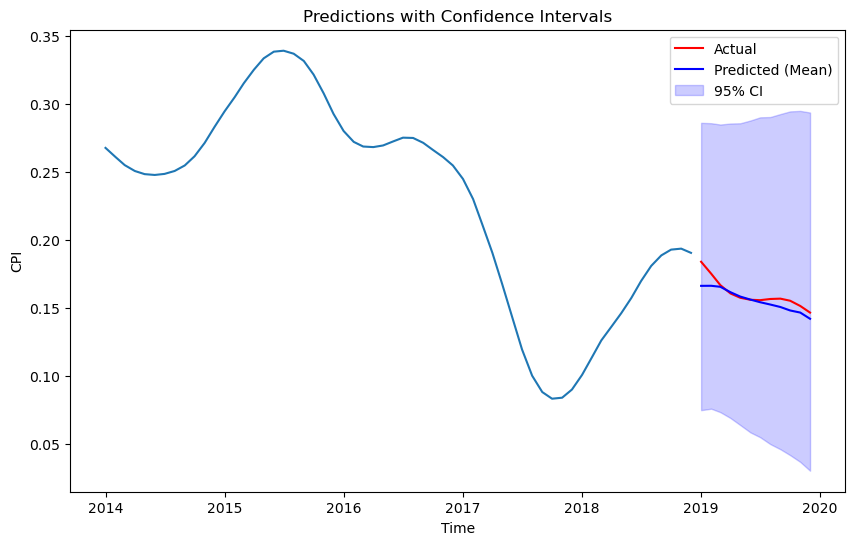

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(y_train['2014':], label=None)
plt.plot(results_en.index, results_en['Actual'], label='Actual', color='red')
plt.plot(results_en.index, results_en['Predicted'], label='Predicted (Mean)', color='blue')
plt.fill_between(results_en.index, results_en['CI Lower'], results_en['CI Upper'], color='blue', alpha=0.2, label='95% CI')
plt.xlabel('Time')
plt.ylabel('CPI')
plt.title('Predictions with Confidence Intervals')
plt.legend()
plt.savefig('../../../output/3_Regression/analysis_16/h19/en_predictions.png')
plt.show()

#### Predictors

In [ ]:
pred_vars = X_train.columns.to_list()
coefficients = en_model.named_steps['regressor'].coef_
vars_df_en      = pd.DataFrame( {'Var': X_train.columns, 'Coefficient': coefficients } )
vars_df_en      = vars_df_en.reindex( vars_df_en[ 'Coefficient' ].abs().sort_values( ascending = False ).index )
vars_df_en.to_excel( f'../../../output/3_Regression/analysis_16/h19/coef_en_h19.xlsx' )

#### Metrics

<Axes: >

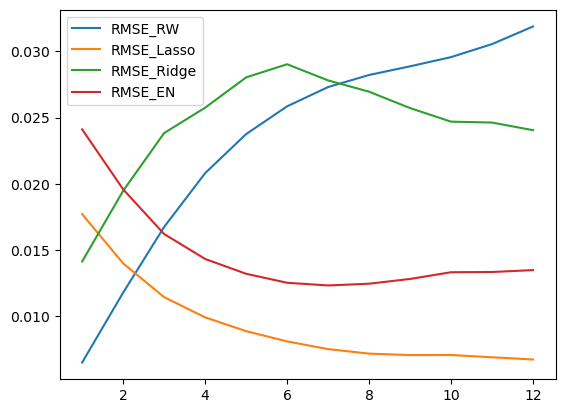

In [ ]:
RMSE_en, MAPE_en = get_metrics(results_en, 'EN')
pd.concat([RMSE_rw, RMSE_lasso, RMSE_ridge, RMSE_en], axis=1).plot()

### 3.2.4 Least Angle Regression (LARS)

In [ ]:
target = "CPI"
Y = pd.DataFrame(df_lags[target])
X = df_lags.drop(columns=[target])

train_set = df_lags[df_lags.index < '2019-01-01']
test_set  = df_lags[df_lags.index >= '2019-01-01']

y_train = train_set[target]
y_test  = test_set[target]
X_train = train_set.loc[:, train_set.columns != target]
X_test  = test_set.loc[:, test_set.columns != target]

# We define the model
scaler = StandardScaler()

# Define model
model = Pipeline([
    ('scaler', scaler),
    ('regressor', Lars(random_state=2024))  
])

# Define grid search
grid_params_lars = {
    'regressor__n_nonzero_coefs': np.arange(1, X.shape[1] + 1)  # Probando diferentes números de coeficientes no nulos
}


#### Bootstrapping

In [ ]:
np.random.seed(2024)
n_bootstraps = 1000
bootstrap_predictions_lars = np.zeros((n_bootstraps, len(y_test)))
boostrap_params_lars = np.zeros((n_bootstraps, 1))

for i in range(n_bootstraps):
    n_iter = np.random.randint(25, 150)
    print(f'Number of iterations: {n_iter}')
    grid_search = RandomizedSearchCV(model, grid_params_lars, cv=tscv, scoring='neg_mean_squared_error', n_iter=n_iter, random_state=i)
    grid_search.fit(X_train, y_train)

    lars_model = grid_search.best_estimator_
    lars_params = grid_search.best_params_

    # Make predictions
    y_pred_bootstrap = lars_model.predict(X_test)

    # Save predictions
    bootstrap_predictions_lars[i] = y_pred_bootstrap
    boostrap_params_lars[i] = lars_params['regressor__n_nonzero_coefs']
    print(f'Bootstrap {i+1} of {n_bootstraps} completed')

# We get the mean and median of the alphas
eta_mean = np.mean(boostrap_params_lars)
eta_median = np.median(boostrap_params_lars)

# Point forecast
y_pred_mean = np.mean(bootstrap_predictions_lars, axis=0)

# Confidence Intervals
ci_lower = np.percentile(bootstrap_predictions_lars, 2.5, axis=0)
ci_upper = np.percentile(bootstrap_predictions_lars, 97.5, axis=0)

# Dataframe with results
results_lars = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred_mean,
    'CI Lower': ci_lower,
    'CI Upper': ci_upper
})
    

#### Parameters

In [ ]:
bootstrap_params_df = pd.DataFrame(boostrap_params_lars, columns=['Eta'])

sns.histplot(bootstrap_params_df.Eta, color='blue', kde=True)
plt.axvline(x=eta_mean, color='black', linestyle='--', label='Mean')
plt.axvline(x=eta_median, color='red', linestyle='--', label='Median')
plt.legend()
plt.title('Distribution of Eta')
plt.savefig('../../../output/3_Regression/analysis_16/h19/lars_bootstrap.png')
plt.show()

#### Plot

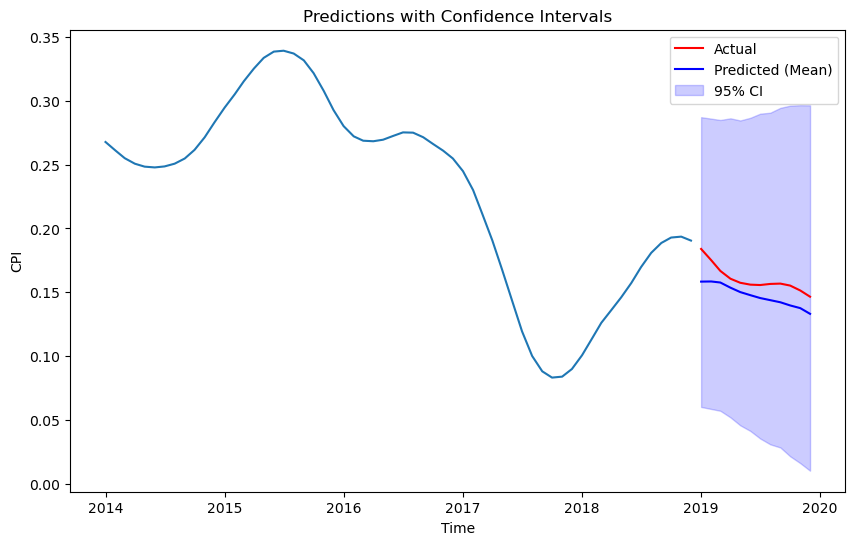

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(y_train['2014':], label=None)
plt.plot(results_lars.index, results_lars['Actual'], label='Actual', color='red')
plt.plot(results_lars.index, results_lars['Predicted'], label='Predicted (Mean)', color='blue')
plt.fill_between(results_lars.index, results_lars['CI Lower'], results_lars['CI Upper'], color='blue', alpha=0.2, label='95% CI')
plt.xlabel('Time')
plt.ylabel('CPI')
plt.title('Predictions with Confidence Intervals')
plt.legend()
plt.savefig('../../../output/3_Regression/analysis_16/h19/lars_predictions.png')
plt.show()

#### Predictors

In [ ]:
pred_vars = X_train.columns.to_list()
coefficients = lars_model.named_steps['regressor'].coef_
vars_df_lars      = pd.DataFrame( {'Var': X_train.columns, 'Coefficient': coefficients } )
vars_df_lars      = vars_df_lars.reindex( vars_df_lars[ 'Coefficient' ].abs().sort_values( ascending = False ).index )
vars_df_lars.to_excel( f'../../../output/3_Regression/analysis_16/h19/coef_lars_h19.xlsx' )

#### Metrics

<Axes: >

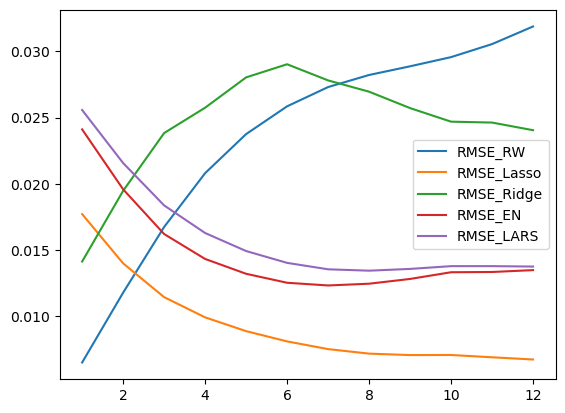

In [ ]:
RMSE_lars, MAPE_lars = get_metrics(results_lars, 'LARS')
pd.concat([RMSE_rw, RMSE_lasso, RMSE_ridge, RMSE_en, RMSE_lars], axis=1).plot()

### 3.2.5 Random Forest Regression (Random Forest)

In [ ]:
target = "CPI"
Y = pd.DataFrame(df_lags[target])
X = df_lags.drop(columns=[target])

train_set = df_lags[df_lags.index < '2019-01-01']
test_set  = df_lags[df_lags.index >= '2019-01-01']

y_train = train_set[target]
y_test  = test_set[target]
X_train = train_set.loc[:, train_set.columns != target]
X_test  = test_set.loc[:, test_set.columns != target]

# Implementing the temporal cross-validation
tscv = TimeSeriesSplit(n_splits=5, test_size= 12)

# We implement the model
scaler = StandardScaler()

# Define model
model = Pipeline([
    ('scaler', scaler),
    ('regressor', RandomForestRegressor(random_state=2024))  
])


# Define grid search
grid_params_rf = {
    'regressor__n_estimators': np.arange(90, 501, 5),  # Genera enteros desde 90 hasta 500 inclusive, con paso de 5
    'regressor__max_depth': np.arange(5, 51),  # Genera enteros desde 5 hasta 50 inclusive
    'regressor__min_samples_split': [2, 5, 10],  # Valores válidos para min_samples_split
    'regressor__min_samples_leaf': [1, 2, 4],    # Valores válidos para min_samples_leaf
    'regressor__max_features': ['auto', 'sqrt', 'log2']
}


#### Bootstraping

In [ ]:
np.random.seed(2024)
n_bootstraps = 1000
bootstrap_predictions_rf = np.zeros((n_bootstraps, len(y_test)))
boostrap_params_rf = np.zeros((n_bootstraps, 4))

for i in range(n_bootstraps):
    n_iter = np.random.randint(25, 150)
    print(f'Number of iterations: {n_iter}')
    grid_search = RandomizedSearchCV(model, grid_params_rf, cv=tscv, scoring='neg_mean_squared_error', n_iter=n_iter, random_state=i)
    grid_search.fit(X_train, y_train)

    rf_model = grid_search.best_estimator_
    rf_params = grid_search.best_params_

    # Make predictions
    y_pred_bootstrap = rf_model.predict(X_test)

    # Save predictions
    bootstrap_predictions_rf[i] = y_pred_bootstrap
    boostrap_params_rf[i] = [rf_params['regressor__n_estimators'], rf_params['regressor__max_depth'], rf_params['regressor__min_samples_split'], rf_params['regressor__min_samples_leaf']]
    print(f'Bootstrap {i+1} of {n_bootstraps} completed')

# We get the mean and median of the alphas
params_mean_rf = np.mean(boostrap_params_rf, axis=0)
params_median_rf = np.median(boostrap_params_rf, axis=0)

# Point forecast
y_pred_mean = np.mean(bootstrap_predictions_rf, axis=0)

# Confidence Intervals
ci_lower = np.percentile(bootstrap_predictions_rf, 2.5, axis=0)
ci_upper = np.percentile(bootstrap_predictions_rf, 97.5, axis=0)

# Dataframe with results
results_rf = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred_mean,
    'CI Lower': ci_lower,
    'CI Upper': ci_upper
})


#### Parameters

In [ ]:
bootstrap_params_df = pd.DataFrame(boostrap_params_rf, columns=['N Estimators', 'Max Depth', 'Min Samples Split', 'Min Samples Leaf'])

sns.histplot(bootstrap_params_df['N Estimators'], color='blue', kde=True)
plt.axvline(x=params_mean_rf[0], color='black', linestyle='--', label='Mean')
plt.axvline(x=params_median_rf[0], color='red', linestyle='--', label='Median')
plt.legend()
plt.title('Distribution of N Estimators')
plt.savefig('../../../output/3_Regression/analysis_16/h19/rf_bootstrap.png')
plt.show()

In [ ]:
sns.histplot(bootstrap_params_df['Max Depth'], color='blue', kde=True)
plt.axvline(x=params_mean_rf[1], color='black', linestyle='--', label='Mean')
plt.axvline(x=params_median_rf[1], color='red', linestyle='--', label='Median')
plt.legend()
plt.title('Distribution of Max Depth')
plt.savefig('../../../output/3_Regression/analysis_16/h19/rf_bootstrap_2.png')
plt.show()

In [ ]:
sns.histplot(bootstrap_params_df['Min Samples Split'], color='blue', kde=True)
plt.axvline(x=params_mean_rf[2], color='black', linestyle='--', label='Mean')
plt.axvline(x=params_median_rf[2], color='red', linestyle='--', label='Median')
plt.legend()
plt.title('Distribution of Min Samples Split')
plt.savefig('../../../output/3_Regression/analysis_16/h19/rf_bootstrap_3.png')
plt.show()

In [ ]:
sns.histplot(bootstrap_params_df['Min Samples Leaf'], color='blue', kde=True)
plt.axvline(x=params_mean_rf[3], color='black', linestyle='--', label='Mean')
plt.axvline(x=params_median_rf[3], color='red', linestyle='--', label='Median')
plt.legend()
plt.title('Distribution of Min Samples Leaf')
plt.savefig('../../../output/3_Regression/analysis_16/h19/rf_bootstrap_4.png')
plt.show()

#### Plot

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(y_train['2014':], label=None)
plt.plot(results_rf.index, results_rf['Actual'], label='Actual', color='red')
plt.plot(results_rf.index, results_rf['Predicted'], label='Predicted (Mean)', color='blue')
plt.fill_between(results_rf.index, results_rf['CI Lower'], results_rf['CI Upper'], color='blue', alpha=0.2, label='95% CI')
plt.xlabel('Time')
plt.ylabel('CPI')
plt.title('Predictions with Confidence Intervals')
plt.legend()
plt.savefig('../../../output/3_Regression/analysis_16/h19/rf_predictions.png')
plt.show()

#### Predictors

In [ ]:
pred_vars = X_train.columns.to_list()
feature_importances = rf_model.named_steps['regressor'].feature_importances_
vars_df_rf             = pd.DataFrame( {'Var': pred_vars, 'Importance Score': feature_importances } )
vars_df_rf             = vars_df_rf.reindex(vars_df_rf[ 'Importance Score' ].abs().sort_values( ascending = False ).index )
vars_df_rf.to_excel( f'../../../output/3_Regression/analysis_16/h19/coef_rf_h19_1.xlsx' )

#### Metrics

<Axes: >

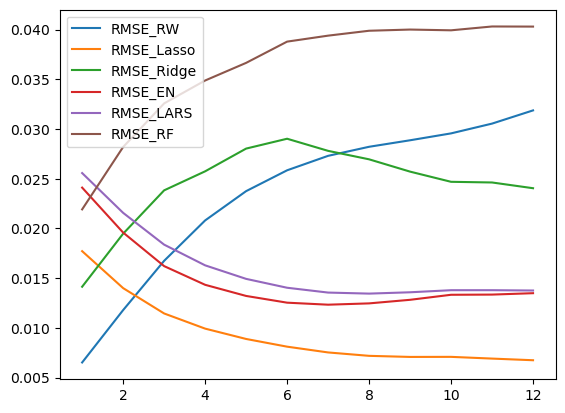

In [ ]:
RMSE_rf, MAPE_rf = get_metrics(results_rf, 'RF')
pd.concat([RMSE_rw, RMSE_lasso, RMSE_ridge, RMSE_en, RMSE_lars, RMSE_rf], axis=1).plot()

### 3.2.5 Support Vector Machine (SVM)

In [ ]:
target = "CPI"
Y = pd.DataFrame(df_lags[target])
X = df_lags.drop(columns=[target])

train_set = df_lags[df_lags.index < '2019-01-01']
test_set  = df_lags[df_lags.index >= '2019-01-01']

y_train = train_set[target]
y_test  = test_set[target]
X_train = train_set.loc[:, train_set.columns != target]
X_test  = test_set.loc[:, test_set.columns != target]

# Implementing the temporal cross-validation
tscv = TimeSeriesSplit(n_splits=5, test_size= 12)

# We implement the model
scaler = StandardScaler()
svm = SVR()
model = Pipeline([
    ('scaler', scaler),
    ('svm', svm)
])

# Define grid search
param_grid_svm = {
    'svm__C': np.linspace(0.1, 100, 100),
    'svm__gamma': ['scale', 'auto'],
    'svm__kernel': ['rbf', 'linear']
}

#### Bootstrapping

In [ ]:
np.random.seed(2024)
n_bootstraps = 1000
bootstrap_predictions_svm = np.zeros((n_bootstraps, len(y_test)))
boostrap_params_svm = np.zeros((n_bootstraps, 3))
bootstrap_gamma_svm = []  
bootstrap_kernel_svm = []  

for i in range(n_bootstraps):
    n_iter = np.random.randint(25, 150)
    print(f'Number of iterations: {n_iter}')
    grid_search = RandomizedSearchCV(model, param_grid_svm, cv=tscv, scoring='neg_mean_squared_error', n_iter=n_iter, random_state=i)
    grid_search.fit(X_train, y_train)

    svm_model = grid_search.best_estimator_
    svm_params = grid_search.best_params_

    # Make predictions
    y_pred_bootstrap = svm_model.predict(X_test)

    # Save predictions
    bootstrap_predictions_svm[i] = y_pred_bootstrap
    boostrap_params_svm[i] = svm_params['svm__C']

    # Save `gamma` and `kernel` 
    bootstrap_gamma_svm.append(svm_params['svm__gamma'])
    bootstrap_kernel_svm.append(svm_params['svm__kernel'])    

    print(f'Bootstrap {i+1} of {n_bootstraps} completed')

# We get the mean and median of the alphas
params_mean_svm = np.mean(boostrap_params_svm, axis=0)
params_median_svm = np.median(boostrap_params_svm, axis=0)

# # We get the mode of the categorical parameters
# params_mode_svm = np.array([stats.mode(boostrap_params_svm[:, i])[0][0] for i in range(3)])

# Point forecast
y_pred_mean = np.mean(bootstrap_predictions_svm, axis=0)

# Confidence Intervals
ci_lower = np.percentile(bootstrap_predictions_svm, 2.5, axis=0)
ci_upper = np.percentile(bootstrap_predictions_svm, 97.5, axis=0)

# Dataframe with results
results_svm = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred_mean,
    'CI Lower': ci_lower,
    'CI Upper': ci_upper
})

#### Parameters

In [ ]:
bootstrap_params_df = pd.DataFrame(boostrap_params_svm, columns=['C', 'Gamma', 'Kernel'])

sns.histplot(bootstrap_params_df['C'], color='blue', kde=True)
plt.axvline(x=params_mean_svm[0], color='black', linestyle='--', label='Mean')
plt.axvline(x=params_median_svm[0], color='red', linestyle='--', label='Median')
plt.legend()
plt.title('Distribution of C')
plt.savefig('../../../output/3_Regression/analysis_16/h19/svm_bootstrap.png')
plt.show()

#### Plot

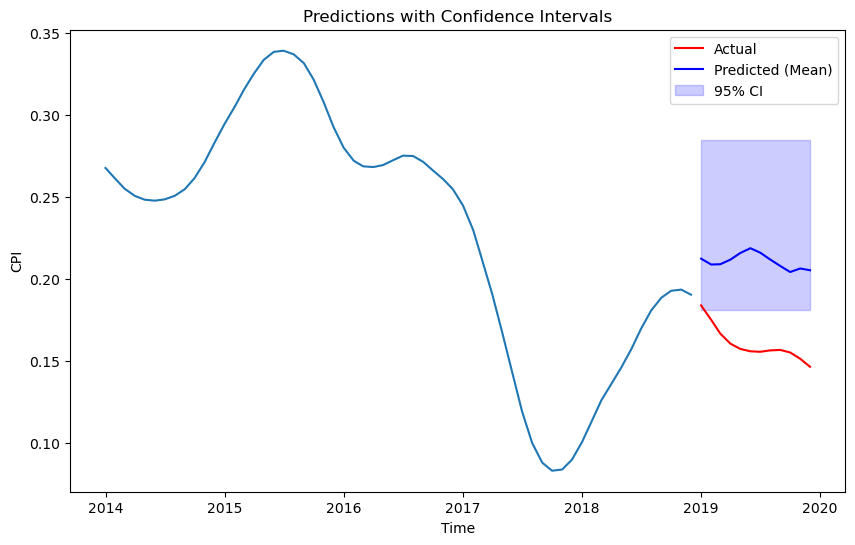

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(y_train['2014':], label=None)
plt.plot(results_svm.index, results_svm['Actual'], label='Actual', color='red')
plt.plot(results_svm.index, results_svm['Predicted'], label='Predicted (Mean)', color='blue')
plt.fill_between(results_svm.index, results_svm['CI Lower'], results_svm['CI Upper'], color='blue', alpha=0.2, label='95% CI')
plt.xlabel('Time')
plt.ylabel('CPI')
plt.title('Predictions with Confidence Intervals')
plt.legend()
plt.show()

#### Metrics 

<Axes: >

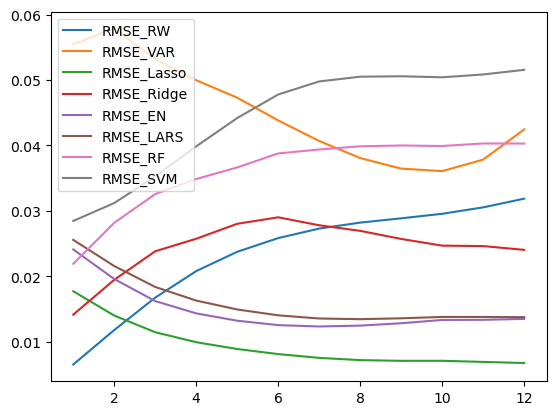

In [ ]:
RMSE_svm, MAPE_svm = get_metrics(results_svm, 'SVM')
pd.concat([RMSE_rw, RMSE_var, RMSE_lasso, RMSE_ridge, RMSE_en, RMSE_lars, RMSE_rf, RMSE_svm], axis=1).plot()

## 3.3 Results
Here we concat all results into a single dataframe. We export the table to excel.


### 3.3.1 General results
Here we will create graphs and tables with the results of all models combined into a single datagrame.

In [ ]:
RMSE_2019 = pd.concat([RMSE_rw, RMSE_var, RMSE_lasso, RMSE_ridge, RMSE_en, RMSE_lars, RMSE_rf, RMSE_svm], axis=1)
MAPE_2019 = pd.concat([MAPE_rw, MAPE_var, MAPE_lasso, MAPE_ridge, MAPE_en, MAPE_lars, MAPE_rf, MAPE_svm], axis=1)

In [ ]:
RMSE_2019

,RMSE_RW,RMSE_VAR,RMSE_Lasso,RMSE_Ridge,RMSE_EN,RMSE_LARS,RMSE_RF,RMSE_SVM
1,0.006527,0.055452,0.017717,0.014141,0.024107,0.025568,0.021917,0.028461
2,0.011793,0.057881,0.014002,0.019474,0.019587,0.021568,0.028188,0.031202
3,0.016746,0.053207,0.011454,0.023831,0.016215,0.018373,0.032572,0.035289
4,0.020805,0.049973,0.009930,0.025743,0.014335,0.016292,0.034873,0.039868
5,0.023751,0.047301,0.008890,0.028029,0.013216,0.014931,0.036646,0.044193
6,0.025846,0.043823,0.008116,0.029020,0.012539,0.014039,0.038782,0.047792
7,0.027300,0.040687,0.007536,0.027802,0.012336,0.013554,0.039383,0.049787
8,0.028210,0.038077,0.007194,0.026950,0.012467,0.013450,0.039875,0.050509
9,0.028865,0.036463,0.007084,0.025713,0.012827,0.013584,0.039996,0.050575
10,0.029558,0.036081,0.007092,0.024690,0.013333,0.013793,0.039919,0.050419


Text(0.5, 1.0, 'RMSE of different models for 2019')

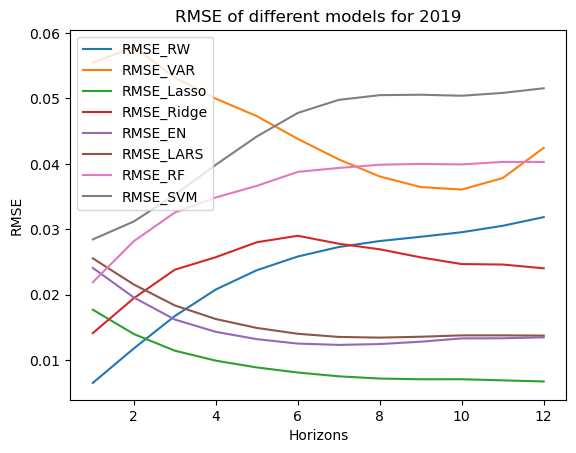

In [ ]:
# Create a figure and axis
fig, ax = plt.subplots()

# Plot the RMSE values for each model
RMSE_2019.plot(ax=ax)

# Set the x-axis label, y-axis label, and title
ax.set_xlabel('Horizons')
ax.set_ylabel('RMSE')
ax.set_title('RMSE of different models for 2019')

# Show the legend
ax.legend()

# Display the plot
plt.show()


In [ ]:
RMSE_2019_results = RMSE_2019.div(RMSE_rw['RMSE_RW'], axis=0)
RMSE_2019_results_highlight = RMSE_2019_results.style.apply(highlight_min, axis=1)
RMSE_2019_results_highlight

,RMSE_RW,RMSE_VAR,RMSE_Lasso,RMSE_Ridge,RMSE_EN,RMSE_LARS,RMSE_RF,RMSE_SVM
1,1.000000,8.496228,2.714559,2.166713,3.693580,3.917477,3.358048,4.360780
2,1.000000,4.907858,1.187272,1.651280,1.660817,1.828838,2.390132,2.645700
3,1.000000,3.177385,0.684001,1.423107,0.968293,1.097179,1.945135,2.107369
4,1.000000,2.401939,0.477295,1.237339,0.689025,0.783088,1.676188,1.916274
5,1.000000,1.991561,0.374323,1.180126,0.556431,0.628672,1.542917,1.860696
6,1.000000,1.695543,0.314012,1.122778,0.485134,0.543193,1.500496,1.849101
7,1.000000,1.490358,0.276031,1.018376,0.451860,0.496501,1.442612,1.823691
8,1.000000,1.349741,0.255006,0.955321,0.441944,0.476773,1.413485,1.790457
9,1.000000,1.263237,0.245435,0.890806,0.444375,0.470600,1.385623,1.752119
10,1.000000,1.220706,0.239922,0.835297,0.451071,0.466637,1.350555,1.705775


In [ ]:
MAPE_2019_results = MAPE_2019.div(MAPE_rw['MAPE_RW'], axis=0)
MAPE_2019_results_highlight = MAPE_2019_results.style.apply(highlight_min, axis=1)
MAPE_2019_results_highlight

,MAPE_RW,MAPE_VAR,MAPE_Lasso,MAPE_Ridge,MAPE_EN,MAPE_LARS,MAPE_RF,MAPE_SVM
1,1.000000,8.496228,2.714559,2.166713,3.693580,3.917477,3.358048,4.360780
2,1.000000,5.240868,1.192445,1.720437,1.697155,1.900324,2.512001,2.820552
3,1.000000,3.387669,0.580476,1.492687,0.891898,1.086461,2.067224,2.263957
4,1.000000,2.526755,0.354263,1.302821,0.604305,0.735843,1.782041,2.038476
5,1.000000,2.057981,0.250328,1.233088,0.481454,0.572418,1.630192,1.952925
6,1.000000,1.675596,0.188549,1.167956,0.421681,0.488906,1.571161,1.919938
7,1.000000,1.383816,0.159227,1.041853,0.400627,0.449212,1.502492,1.882924
8,1.000000,1.172934,0.152771,0.967774,0.399511,0.436953,1.464877,1.841665
9,1.000000,1.088677,0.156921,0.881724,0.407653,0.436575,1.430270,1.796539
10,1.000000,1.067261,0.162890,0.812420,0.418197,0.437257,1.389719,1.744598


In [ ]:
tableH19 = RMSE_2019_results
tableH19 = tableH19.rename(columns = {'RMSE_RW': 'RW', 'RMSE_VAR': 'VAR', 'RMSE_Ridge': 'Ridge', 'RMSE_EN':'Elastic Net',
                            'RMSE_Lasso': 'Lasso', 'RMSE_LARS':'LARS', 'RMSE_RF':'RF', 'RMSE_SVM':'SVM'})
tableH19.index.name = 'horizon'
tableH19.to_excel("../../../output/3_Regression/analysis_16/h19/table_rmse_h19_analysis_16.xlsx")

In [ ]:
tableH19 = MAPE_2019_results
tableH19 = tableH19.rename(columns = {'MAPE_RW': 'RW', 'MAPE_VAR': 'VAR', 'MAPE_Ridge': 'Ridge', 'MAPE_EN':'Elastic Net',
                            'MAPE_Lasso': 'Lasso', 'MAPE_LARS':'LARS', 'MAPE_RF':'RF', 'MAPE_SVM':'SVM'})
tableH19.index.name = 'horizon'
tableH19.to_excel("../../../output/3_Regression/analysis_16/h19/table_mape_h19_analysis_16.xlsx")

In [ ]:
# graph_models(RMSE_2019_results, lim=2.5, colors=colors, path="../../../output/3_Regression/analysis_16/h19/h_rmse.png")

In [ ]:
# colors = {'MAPE_VAR': 'tab:red', 'MAPE_Ridge': 'tab:brown', 'MAPE_Lasso': 'tab:purple', 'MAPE_RF': 'tab:pink'}

# graph_models(MAPE_2019_results, metric = "MAPE", lim=1.5, colors=colors, path="../../../output/3_Regression/analysis_16/h19/mape.png")

### 3.3.2 Coefficients by model

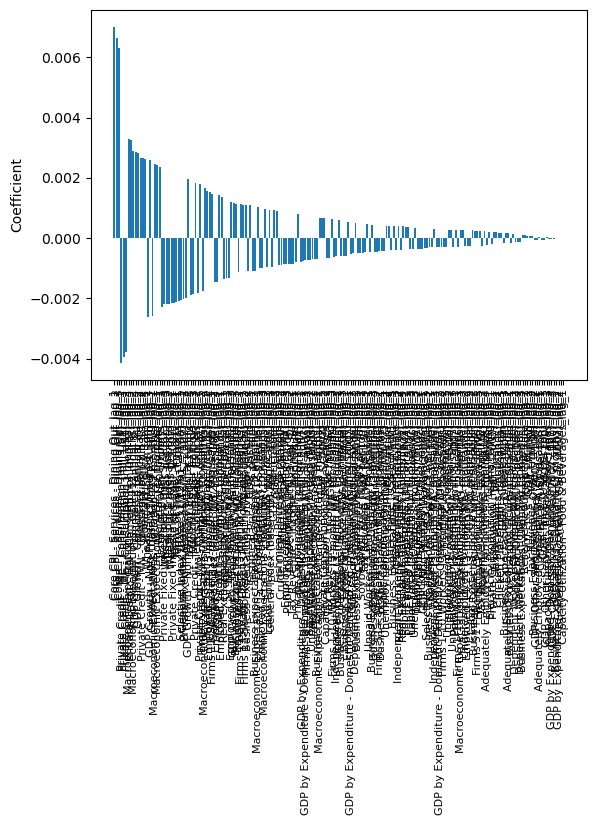

In [ ]:
graph_coefficients(vars_df_ridge, value = "Coefficient", path="../../../output/3_Regression/analysis_16/h19/ridge_coef.png")

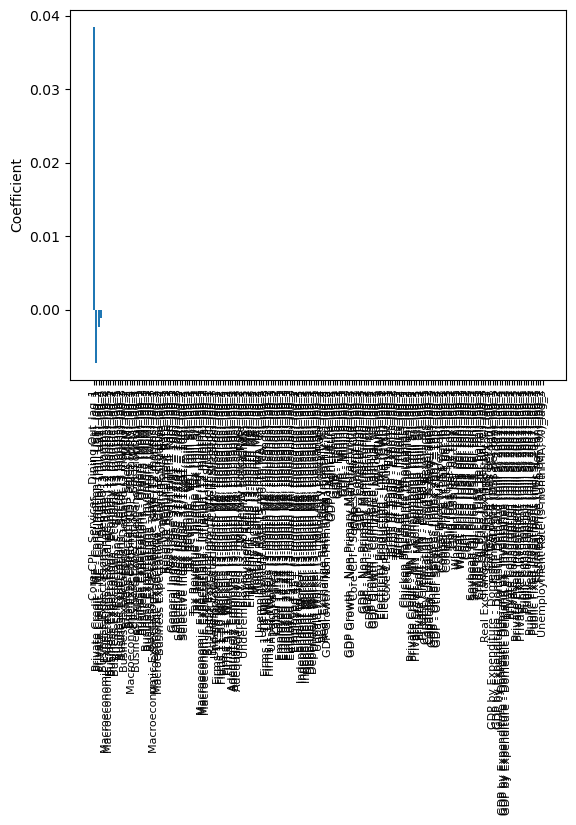

In [ ]:
graph_coefficients(vars_df_lasso, value = "Coefficient", path="../../../output/3_Regression/analysis_16/h19/lasso_coef.png")

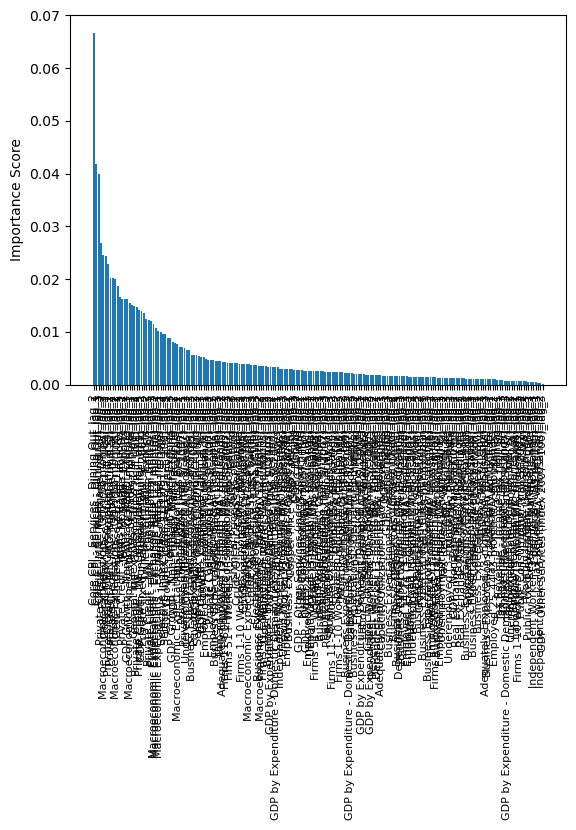

In [ ]:
graph_coefficients(vars_df_rf, value = "Importance Score", path="../../../output/3_Regression/analysis_16/h19/rf_coef.png")

### 3.3.3 Prediction plots
We are going to plot our predictions in a single plot to compare visually how different models performed

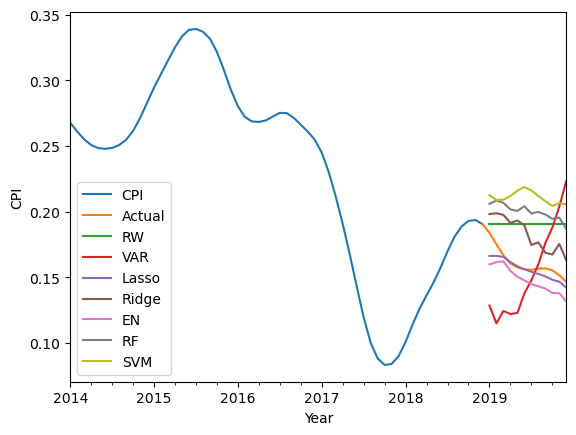

In [ ]:
# Plot the actual and predicted values for different models
y_train['2014':].plot(label=None)
df['CPI']['2018-12-01':].plot(label='Actual')
results_rw['Predicted'].plot(label='RW')
results_var['Predicted'].plot(label='VAR')
results_lasso['Predicted'].plot(label='Lasso')
results_ridge['Predicted'].plot(label='Ridge')
results_en['Predicted'].plot(label='EN')
results_rf['Predicted'].plot(label='RF')
results_svm['Predicted'].plot(label='SVM')

# Set the labels and title for the plot
plt.xlabel('Year')
plt.ylabel('CPI')

# Add a legend to the plot
plt.legend()

# Save the plot to a file
plt.savefig('../../../output/3_Regression/analysis_16/h19/model_final_analysis_16.png', bbox_inches='tight', dpi=300)

### 3.3.4 Dielbold-Mariano test
We implement the diebold-mariano test to see if the different in forecasts is statistically significant.

We conclude that:
- The RW appears to be better than the VAR, but it is not statiscally significant
- While the RW appers to have worse forecast predictions than the ML models, it is not statistically outperformed by the other models.

## 3.3.5 Best parameters
We here print the best parameters the Gridsearch selected for each model

In [ ]:
print(lasso_params)
print(ridge_params)
print(en_params)
print(lars_params)
print(rf_params)
print(svm_params)


{'regressor__alpha': 0.02}
{'regressor__alpha': 2.26}
{'regressor__n_estimators': 200, 'regressor__min_samples_split': 5, 'regressor__min_samples_leaf': 1, 'regressor__max_features': 'log2', 'regressor__max_depth': 43}


In [68]:
ridge_params

{'regressor__alpha': 1.97}